In [1]:
# !pip install nltk spacy beautifulsoup4 rank-bm25 tqdm pandas numpy matplotlib

In [2]:
from copy import deepcopy
import pickle, re, string, json, os

from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_styles import *

from bs4 import BeautifulSoup as BS
from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from spacy.lang.en.stop_words import STOP_WORDS

def show_sample(d):
    for k, v in d.items():
        print('{}: {}'.format(k, v))

[nltk_data] Downloading package punkt to /home/dojo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dojo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Combined Dataset from `get-wiki-data.ipynb`

In [3]:
PATH = 'data'
if not os.path.exists(PATH):
    os.makedirs(PATH)

# Extract relevant passages from wiki

In [4]:
# set this to False if you have just completed running `wiki_download.ipynb`
use_saved = True

In [5]:
def sent_tokenize(text):
    sentences = re.split(r"[.!?]", text)
    sentences = [sent.strip(" ") for sent in sentences]
    return sentences

def pre_processing(collection):
    collection = collection.lower()
    collection = collection.translate(str.maketrans('','',string.punctuation))
    collection = re.sub(r'\d+', '', collection)
    collection = collection.strip()

    lemmatizer=WordNetLemmatizer()
    collection=word_tokenize(collection)
    
    collection_clean = []
    for word in collection:
        collection_clean.append(lemmatizer.lemmatize(word))
        
    stop_words = set(STOP_WORDS)
    collection_clean = [i for i in collection_clean if not i in stop_words]
    
    return collection_clean
if not use_saved:
    # The below needs to be downloaded - instructions in README.md
    raw_df = pd.read_pickle(PATH + '/combined-dataset.pkl')
    
    clues = []
    responses = []
    categories = []
    scores_bm25 =[]
    passages = []

    for index, row in tqdm(raw_df.iterrows(), total=raw_df.shape[0]):
        query = row[' Question'] + ' ' + row[' Answer']
        passage_ss = sent_tokenize(row['wiki'])

        tokenized_corpus = [pre_processing(doc) for doc in passage_ss]
        bm25 = BM25Okapi(tokenized_corpus)
        tokenized_query = pre_processing(query)
        doc_scores = bm25.get_scores(tokenized_query)

        score_argmax = np.argmax(doc_scores)
        if score_argmax == 0:
            best_sentences = passage_ss[:score_argmax + 3]
        elif score_argmax == len(passage_ss) - 1:
            best_sentences = passage_ss[score_argmax - 3:]
        else:
            best_sentences = passage_ss[score_argmax - 1:score_argmax + 2]

        responses.append(row[' Answer'])
        clues.append(row[' Question'])
        categories.append(row[' Category'])
        passages.append('. '.join(best_sentences).replace('\n', ' ').replace('\'"', '"'))
        scores_bm25.append(doc_scores[score_argmax])

    data_raw = {
        'clues': clues,
        'responses': responses,
        'categories': categories,
        'scores_bm25': scores_bm25,
        'passages': passages 
    }

    pickle.dump(data_raw, open(PATH + '/data-w-scores.pkl', 'wb'))
else:
    data_raw = pickle.load(open(PATH + '/data-w-scores.pkl', 'rb'))

## See Example Datapoint

In [6]:
data_raw['clues'][28]

'<a href="http://www.j-archive.com/media/2004-12-31_DJ_26.mp3">Ripped from today\'s headlines, he was a turtle king gone mad; Mack was the one good turtle who\'d bring him down</a>'

## Preprocess `<a>` tags

In [7]:
data_notags = deepcopy(data_raw)
count = 0
idxs = []
for i in tqdm(range(len(data_notags['passages']))):
    if '://' in data_notags['passages'][i]:
        count += 1
        data_notags['passages'][i] = BS(data_notags['passages'][i], 'html.parser').get_text()
    if '://' in data_notags['clues'][i]:
        count += 1
        data_notags['clues'][i] = BS(data_notags['clues'][i], 'html.parser').get_text()
count

100%|██████████| 149006/149006 [00:01<00:00, 144577.10it/s]


7305

In [8]:
data_notags['clues'][28]

"Ripped from today's headlines, he was a turtle king gone mad; Mack was the one good turtle who'd bring him down"

## Remove Oddly formatted links

In [9]:
data_notags['passages'][13090]

'is/20131116140756/https://sites. google. com/site/levistraussfamily/ Biography of Levi Strauss from the Official Levi Strauss Site.  Levi Strauss at Find a Grave Levi Strauss Museum in Buttenheim, Germany (in German) Levi Strauss at FMD'

In [10]:
count = 0
naughty_idxs = []
for i in tqdm(range(len(data_notags['passages']))):
    if '://' in data_notags['passages'][i] or '://' in data_notags['clues'][i]:
        count += 1
        naughty_idxs.append(i)

100%|██████████| 149006/149006 [00:00<00:00, 1186694.96it/s]


In [11]:
print('found {} bad samples'.format(count))

found 27 bad samples


In [12]:
# form dataframe
df_notags = pd.DataFrame(data_notags)
old_length = len(df_notags)
print('currently have {} samples'.format(old_length))

currently have 149006 samples


Show bad examples that have bad links

In [13]:
df_notags.iloc[naughty_idxs][['clues', 'passages']]

,clues,passages
348,"Movie in which Axel Foley asks, ""where ...you ...","On November 14, 2019, Deadline Hollywood annou..."
5075,"Formed by plate tectonics, these mid-ocean upl...",An Ice pressure ridge develops in an ice cover...
9227,http://www.j-archive.com/Read all about me at ...,The slash is an oblique slanting line punctuat...
13090,The logo seen here has identified this brand s...,is/20131116140756/https://sites. google. com/s...
16359,The seat of Montana State University is named ...,Archives John M. Bozeman's papers are now he...
31351,"Plate armor first covered, then replaced this ...",com/patterns/european/index. html http://www. ...
33489,Joely Richardson starred as Marie Antoinette i...,in both instances. References External links...
38619,"Popular during Christmas, he's the holy man et...",Saint Nicholas Center: Who is Saint Nicholas....
49539,"Forever, or a fragrance by Calvin Klein","The circle, band or ring is also commonly used..."
57957,This fictional rural girl charms a businessman...,Shirley Temple played Rebecca in the more free...


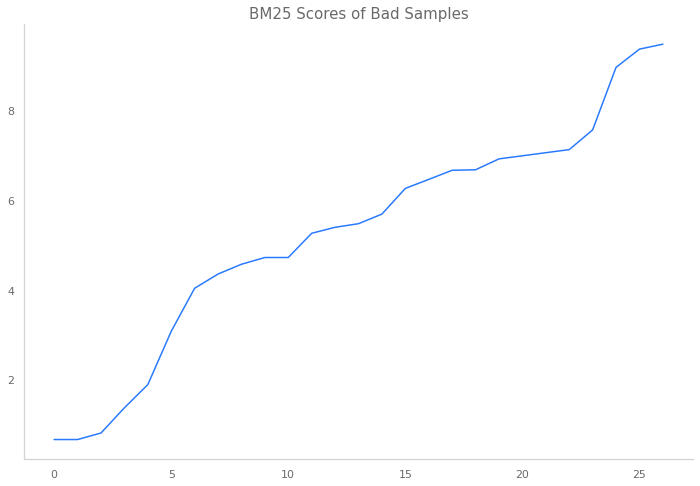

In [14]:
scores_naughty = np.array(data_notags['scores_bm25'])[naughty_idxs]
scores_naughty.sort()
plt.title('BM25 Scores of Bad Samples')
plt.plot(scores_naughty);

Nothing above bm25 score of 10, hence we can drop them.

In [15]:
df_nourls = df_notags.drop(idxs).reset_index(drop=True)
df_nourls

,clues,responses,categories,scores_bm25,passages
0,"For the last 8 years of his life, Galileo was ...",Copernicus,HISTORY,15.476244,"The corrections to De revolutionibus, which om..."
1,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,ESPN's TOP 10 ALL-TIME ATHLETES,10.516087,"Baseball, football, and other sports Thorpe ..."
2,The city of Yuma in this state has a record av...,Arizona,EVERYBODY TALKS ABOUT IT...,10.246053,"In the state's urban centers, the effects of l..."
3,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,THE COMPANY LINE,5.412499,McDonald's has taken to partnering up with Sin...
4,"Signer of the Dec. of Indep., framer of the Co...",John Adams,EPITAPHS & TRIBUTES,12.932640,Adams was the primary author of the Massachuse...
...,...,...,...,...,...
149001,"Shivers walking through 718 Fifth Ave., the je...",Harry Winston,SYMPTOMS OF AFFLUENZA,7.199821,in New York City in 1932. He had been called b...
149002,He came to America in 1847 to join his brother...,Levi Strauss,COMING TO AMERICA,7.131343,He was the son of Hirsch Strauss and his secon...
149003,This popular 1920s dance style was named for a...,the Charleston,SWEET CAROLINA,24.781041,The Charleston is a dance named after the harb...
149004,"In the fir tree, not flowers but these hold th...",cones,YOU DON'T BRING ME FLOWERS,1.667977,A cone with a polygonal base is called a pyram...


# Remove Disambiguations

In [16]:
df_nort = df_nourls.drop(df_nourls[df_nourls.passages.str.contains('refer to:')].index)
df_nort = df_nort.drop(df_nort[df_nort.passages.str.contains('refers to:')].index).reset_index(drop=True)

# Remove Records without Keyword

In [17]:
nkw_idxs = []
for i in tqdm(range(len(df_nort))):
    row = df_nort.iloc[i]
    if row['responses'].lower() not in row['passages'].lower():
        nkw_idxs.append(i)
print(len(nkw_idxs), 'found')

100%|██████████| 145169/145169 [00:21<00:00, 6713.82it/s]

58502 found


In [18]:
df_kw = df_nort.drop(nkw_idxs)

In [19]:
df_sorted = df_kw.sort_values('scores_bm25', ascending=False).reset_index(drop=True)

# Perform Thresholding According to Article Relevance

In [20]:
THRESHOLD = 15

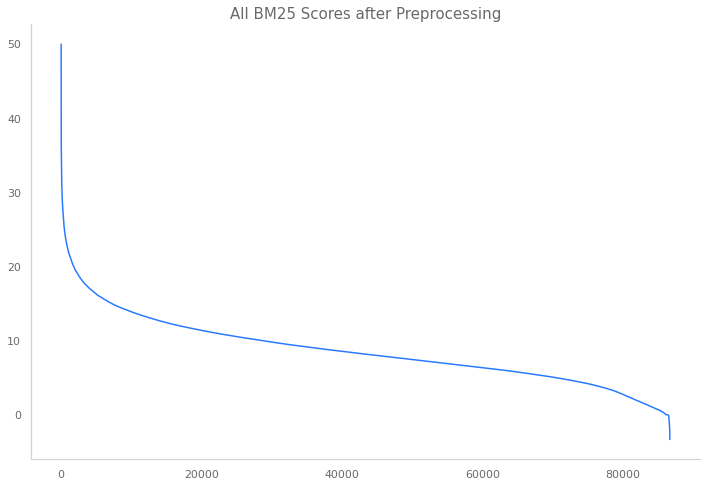

In [21]:
plt.title('All BM25 Scores after Preprocessing')
plt.plot(df_sorted['scores_bm25']);

There are 7181 samples above 15


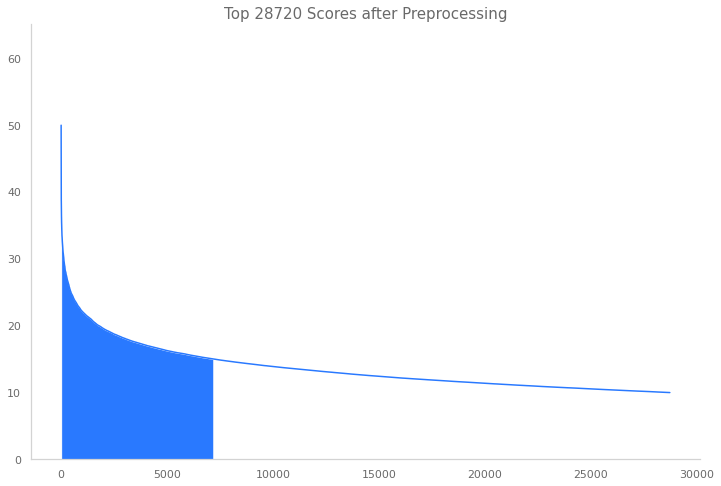

In [22]:
thres_idx = np.where(df_sorted['scores_bm25'] < THRESHOLD)[0][0]
plt.title('Top {} Scores after Preprocessing'.format(4*thres_idx))
plt.ylim([0, 65])
plt.fill_between(range(0, thres_idx), df_sorted['scores_bm25'][:thres_idx])
plt.plot(df_sorted['scores_bm25'][:4*thres_idx]);
print('There are {} samples above {}'.format(thres_idx+1, THRESHOLD))

The worst one within our threshold

In [23]:
show_sample(df_sorted.loc[thres_idx-1].to_dict())

clues: In 1791 John Rutledge left the U.S. Supreme Court to be chief justice of this feisty Southern state, his home
responses: South Carolina
categories: PEOPLE IN HISTORY
scores_bm25: 15.000310949751704
passages: In Texas vs. White (1869), the Supreme Court ruled the ordinances of secession (including that of South Carolina) were invalid, and thus those states had never left the Union. However, South Carolina did not regain representation in Congress until that date


## Cut off below the threshold above

In [24]:
df = df_sorted[df_sorted['scores_bm25'] > THRESHOLD]

In [25]:
df

,clues,responses,categories,scores_bm25,passages
0,"""In the souls of the people"" these ""are fillin...",The Grapes of Wrath,NOVEL TITLES,49.935663,The phrase also appears at the end of Chapter...
1,She played Sissy in the Broadway & film versio...,Cher,REPRISE,45.059679,"After her divorce from Sonny Bono in 1975, she..."
2,(Jon of the Clue Crew reports from Duke Univer...,Nixon,HAIL TO THE CHIEF,42.499861,Nixon was born into a poor family of Quakers ...
3,"""A Funny Thing Happened on the Way to the Foru...",Phil Silvers,PHILMOGRAPHIES,40.673235,Army post in which he played Master Sergeant E...
4,The idea for this device occurred when a magne...,the microwave,UNFORESEEN FINDS,40.011858,"Mouromtseff at Westinghouse, and at the 1933 C..."
...,...,...,...,...,...
7175,"As act one of this musical draws to a close, t...",Titanic,KILLER MUSICALS,15.002277,"m. (ship's time) on 14 April, lookout Frederic..."
7176,"This corrosive substance, H2SO4, was once know...",Sulphuric Acid,CHEMISTRY,15.002223,Sulfuric acid (American spelling) or sulphuric...
7177,"(Hi, I'm Chuck Woolery.) In this board game, ...",Scrabble,RAINY DAY FUN,15.002130,"Next, players decide the order in which they..."
7178,The North African enclaves of Ceuta & Melilla,Spain,IT'S OUR TERRITORY,15.001937,Its territory also includes two archipelagos: ...


In [26]:
all_data = [v for v in df.to_dict(orient='index').values()]

In [27]:
all_data[:2]

[{'clues': '"In the souls of the people" these "are filling and growing heavy, growing heavy for the vintage"',
  'responses': 'The Grapes of Wrath',
  'categories': 'NOVEL TITLES',
  'scores_bm25': 49.9356634638926,
  'passages': " The phrase also appears at the end of Chapter 25 in Steinbeck's book, which describes the purposeful destruction of food to keep the price high:  [A]nd in the eyes of the hungry there is a growing wrath. In the souls of the people the grapes of wrath are filling and growing heavy, growing heavy for the vintage.  The image invoked by the title serves as a crucial symbol in the development of both the plot and the novel's greater thematic concerns: from the terrible winepress of Dust Bowl oppression will come terrible wrath but also the deliverance of workers through their cooperation"},
 {'clues': 'She played Sissy in the Broadway & film versions of "Come Back to the Five and Dime, Jimmy Dean, Jimmy Dean"',
  'responses': 'Cher',
  'categories': 'REPRISE',
 

In [28]:
json.dump(all_data, open(PATH + '/all_data.json', 'w', encoding='utf-8'))

In [29]:
# # Code for imitating squad format
# data_list = []
# unique_cats = list(set(data['categories']))

# for cat in tqdm(unique_cats):
#     indices = [i for i, x in enumerate(data['categories']) if x == cat]

#     data_list.append({
#         "title": cat,
#         "paragraphs": [
#             {
#                 "context": data['passages'][i],
#                 "qas": [{
#                     "answers": [{
#                         "answer_start": 0,
#                         "text": data['responses'][i]
#                     }],
#                     "question": data['clues'][i],
#                     "id": uuid.uuid4().hex
#                 }]
#             } for i in indices
#         ]
#     })

# # main_json = {
# #     "root": {
# #         "data": data_list
# #     }
# # }
# # main_json

In [30]:
N = len(all_data)
train_dev_idx = int(0.8 * N)
all_idxs = np.arange(N)
np.random.shuffle(all_idxs)
idxs_train = all_idxs[:train_dev_idx]
idxs_dev = all_idxs[train_dev_idx:]

data_arr = np.array(all_data)
data_train = data_arr[idxs_train].tolist()
data_dev = data_arr[idxs_dev].tolist()

In [31]:
assert len(data_train) + len(data_dev) == len(all_data), 'Data sizes do not match'

In [32]:
json.dump(data_train, open(PATH + '/data_train.json', 'w', encoding='utf-8'))
json.dump(data_dev, open(PATH + '/data_dev.json', 'w', encoding='utf-8'))